In [1]:
import numpy as np, pandas as pd, geopandas as gpd
import os
import matplotlib.pyplot as plt
import geopandas
import matplotlib.colors as colors

%load_ext nb_black
%config IPCompleter.greedy=True
%matplotlib inline

<IPython.core.display.Javascript object>

In [73]:
from matplotlib import rcParams

rcParams["font.family"] = "Garamond"
rcParams["font.size"] = 14
rcParams["axes.spines.right"] = False
rcParams["axes.spines.top"] = False
rcParams["axes.spines.left"] = False
rcParams["axes.spines.bottom"] = False

rcParams["xtick.bottom"] = False
rcParams["xtick.labelbottom"] = False
rcParams["ytick.left"] = False
rcParams["ytick.labelleft"] = False

<IPython.core.display.Javascript object>

In [4]:
countries = gpd.read_file("data/GIS/TM_WORLD_BORDERS-0.3.shp")
countries = countries.to_crs("+proj=eqearth")
countries.crs

'+proj=eqearth'

<IPython.core.display.Javascript object>

In [5]:
country_df = pd.read_csv("data/country_data.csv", encoding="latin-1")
country_df.head()

,Economy,Code,Region,Income group,Lending category,Other
0,Afghanistan,AFG,South Asia,Low income,IDA,HIPC
1,Albania,ALB,Europe & Central Asia,Upper middle income,IBRD,NaN
2,Algeria,DZA,Middle East & North Africa,Upper middle income,IBRD,NaN
3,American Samoa,ASM,East Asia & Pacific,Upper middle income,..,NaN
4,Andorra,AND,Europe & Central Asia,High income,..,NaN


<IPython.core.display.Javascript object>

In [6]:
# ### Create wb_df and indicator_df tables
# def addIndicatorToMainTable(df, wb_df, indicator_df, short_code):

#     df.dropna(axis=1, how="all", inplace=True)

#     # add to indicator table
#     indicator_cols = ["Indicator Name", "Indicator Code"]
#     indic_df = df[indicator_cols].drop_duplicates()
#     indic_df["Indicator Short Code"] = short_code
#     indicator_df = indicator_df.append(indic_df, sort=False)

#     # melt table
#     df.drop(columns=indicator_cols, inplace=True)
#     df_m = df.melt(
#         id_vars=["Country Name", "Country Code"], var_name="year", value_name=short_code
#     )

#     # add to main table
#     if len(wb_df.columns) == 2:
#         wb_df = wb_df.merge(df_m, on=["Country Name", "Country Code"], how="outer")
#     else:
#         wb_df = wb_df.merge(
#             df_m, on=["Country Name", "Country Code", "year"], how="outer"
#         )
#     return wb_df, indicator_df

# indicator_list = ["GDP.MKTP", "GDP.PCAP", "CO2E.KT", "CO2E.PC", "GHGT.KT"]

# indicator_df = pd.DataFrame(
#     columns=["Indicator Name", "Indicator Code", "Indicator Short Code"]
# )

# # loop through tables and create wb_df and inidicator_df tables
# for indic in indicator_list:
#     for folder in os.listdir("data"):
#         if indic in folder and "zip" not in folder:
#             # print(folder)
#             for file in os.listdir("data/" + folder):
#                 # print(file)
#                 df = pd.read_csv("data/{}/{}".format(folder, file), skiprows=4)
#                 # create wb_df if doesnt exist
#                 if "wb_df" not in locals():
#                     wb_df = df[["Country Name", "Country Code"]]
#                 wb_df, indicator_df = addIndicatorToMainTable(
#                     df, wb_df, indicator_df, short_code=indic
#                 )
#                 break

# # convert_year to int
# wb_df["year"] = wb_df["year"].astype("int")

# # sort values by country and year
# wb_df.sort_values(by=["Country Name", "year"], inplace=True)

# ## save wb_df and indicator_df
# wb_df.to_csv("data/co2_gdp_wb.csv", index=False)
# indicator_df.to_csv("data/indicators.csv", index=False)

<IPython.core.display.Javascript object>

In [7]:
wb_df = pd.read_csv("data/co2_gdp_wb.csv")
# remove zero and negative values
wb_df.loc[wb_df["CO2E.PC"] <= 0, "CO2E.PC"] = np.nan
# gdp per co2 per capita
wb_df["PGDP.CO2.PCAP"] = wb_df["GDP.PCAP"] / wb_df["CO2E.PC"]
wb_df.columns

Index(['Country Name', 'Country Code', 'year', 'GDP.MKTP', 'GDP.PCAP',
       'CO2E.KT', 'CO2E.PC', 'GHGT.KT', 'PGDP.CO2.PCAP'],
      dtype='object')

<IPython.core.display.Javascript object>

In [8]:
gdp_pco2_df = wb_df[
    ["Country Name", "Country Code", "year", "CO2E.PC", "GDP.PCAP", "PGDP.CO2.PCAP"]
]
gdp_pco2_df.head()

,Country Name,Country Code,year,CO2E.PC,GDP.PCAP,PGDP.CO2.PCAP
0,Afghanistan,AFG,1960,0.046057,NaN,NaN
1,Afghanistan,AFG,1961,0.053589,NaN,NaN
2,Afghanistan,AFG,1962,0.073721,NaN,NaN
3,Afghanistan,AFG,1963,0.074161,NaN,NaN
4,Afghanistan,AFG,1964,0.086174,NaN,NaN


<IPython.core.display.Javascript object>

In [9]:
def cleanTable(col):
    gdp_pco2_pivot = (
        gdp_pco2_df.replace(0, np.nan)
        .pivot(index="year", columns="Country Code", values=col)
        .dropna(how="all")
    )
    df = (
        gdp_pco2_pivot.transpose()
        .reset_index()
        .melt(id_vars="Country Code", value_name=col)
    )
    name_code = gdp_pco2_df[["Country Code", "Country Name"]]
    df = df.merge(name_code, on="Country Code").drop_duplicates().reset_index(drop=True)

    return df[["Country Name", "Country Code", "year"] + [col]]

<IPython.core.display.Javascript object>

In [53]:
# dict of columns labels
val_lab = {"CO2E.PC": "CO2 emissions (ton per capita)"}

# value min and max
def vmin_vmax(df, col):
    vmin = df[col].replace(0, np.nan).min()
    vmax = df[col].max()

    return vmin, vmax

<IPython.core.display.Javascript object>

In [87]:
def createWorldPlot(cntry_y, col, filelist, vmin, vmax):

    y = cntry_y["year"].unique().item()
    fig, ax = plt.subplots(1, 1, figsize=(7.5, 7.5), dpi=300)

    # divider = make_axes_locatable(ax)
    # cax1 = divider.append_axes("bottom", size="5%", pad=0)
    # vmin = cntry_y["PGDP.CO2.PCAP"].min()
    # vmax = 500

    cntry_y.dropna().plot(
        column=col,
        ax=ax,
        cmap="coolwarm",
        alpha=0.9,
        norm=colors.LogNorm(vmin=vmin, vmax=vmax),
    )
    plt.axis("off")
    countries.plot(color="none", edgecolor="black", ax=ax, linewidth=0.1)

    sm = plt.cm.ScalarMappable(
        cmap="coolwarm", norm=colors.LogNorm(vmin=vmin, vmax=vmax)
    )
    cbaxes = fig.add_axes([0.2, 0.285, 0.66, 0.03])
    cbar = fig.colorbar(sm, cax=cbaxes, orientation="horizontal", label=val_lab[col])
    fig.text(0.25, 0.4, y, weight="bold", size=18)

    path = "graphs/maps"
    if col not in os.listdir(path):
        os.mkdir("{}/{}".format(path, col))
    filename = "{}/{}/{}.png".format(path, col, y)
    filelist = filelist.append(filename)
    fig.savefig(filename, bbox_inches="tight")
    plt.close("all")

<IPython.core.display.Javascript object>

In [71]:
columns = ["CO2E.PC", "GDP.PCAP", "PGDP.CO2.PCAP"]
col = "CO2E.PC"

df = cleanTable(col)
df.head()

,Country Name,Country Code,year,CO2E.PC
0,Aruba,ABW,1960,NaN
1,Aruba,ABW,1961,NaN
2,Aruba,ABW,1962,NaN
3,Aruba,ABW,1963,NaN
4,Aruba,ABW,1964,NaN


<IPython.core.display.Javascript object>

In [88]:
col = "CO2E.PC"
df = cleanTable(col)
filelist = []
for year in df.year.sort_values().unique():
    vmin, vmax = vmin_vmax(df, col)
    y_df = df.loc[df.year == year].reset_index(drop=True)
    cntry_y = countries[["ISO3", "geometry"]].merge(
        y_df, left_on="ISO3", right_on="Country Code"
    )
    createWorldPlot(cntry_y, col, filelist, vmin, vmax)
# print(filelist)


## Clean Table (remova na years)

# test = gdp_pco2_pivot.loc[(gdp_pco2_pivot.index > 2014)]

# test.transpose().dropna()

<IPython.core.display.Javascript object>

In [89]:
del frames

<IPython.core.display.Javascript object>

In [86]:
## Create GIF
# from PIL import Image

# frames = []
# for filename in filelist:
#     im = Image.open(filename)
#     frames.append(im)

# frames[0].save(
#     "graphs/maps/{}.gif".format(col),
#     format="GIF",
#     append_images=frames[1:],
#     save_all=True,
#     duration=100,
#     loop=0,
# )
import imageio

images = []
for filename in filelist:
    images.append(imageio.imread(filename))
imageio.plugins.freeimage.download()
imageio.mimsave("graphs/maps/{}.gif".format(col), images, "GIF-FI", duration=0.1)

Imageio: 'freeimage-3.15.1-win64.dll' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/freeimage/FreeImage-3.15.1-win64.dll (3.4 MB)
Downloading: 8192/3527168 bytes (0.2%32768/3527168 bytes (0.9212992/3527168 bytes (6.0%458752/3527168 bytes (13.0835584/3527168 bytes (23.71196032/3527168 bytes (33.9%1228800/3527168 bytes (34.8%2129920/3527168 bytes (60.4%2424832/3527168 bytes (68.7%2588672/3527168 bytes (73.4%3309568/3527168 bytes (93.8%3506176/3527168 bytes (99.4%3527168/3527168 bytes (100.0%)
  Done
File saved as C:\Users\eliav\AppData\Local\imageio\freeimage\freeimage-3.15.1-win64.dll.


<IPython.core.display.Javascript object>

In [69]:
frames[0].save(
    "graphs/maps/{}.gif".format(col),
    format="GIF",
    append_images=frames[1:],
    save_all=True,
    duration=100,
    loop=0,
    quality_val=300,
)

<IPython.core.display.Javascript object>

ISO3             object
geometry         object
Country Name     object
Country Code     object
year             object
CO2E.PC         float64
dtype: object

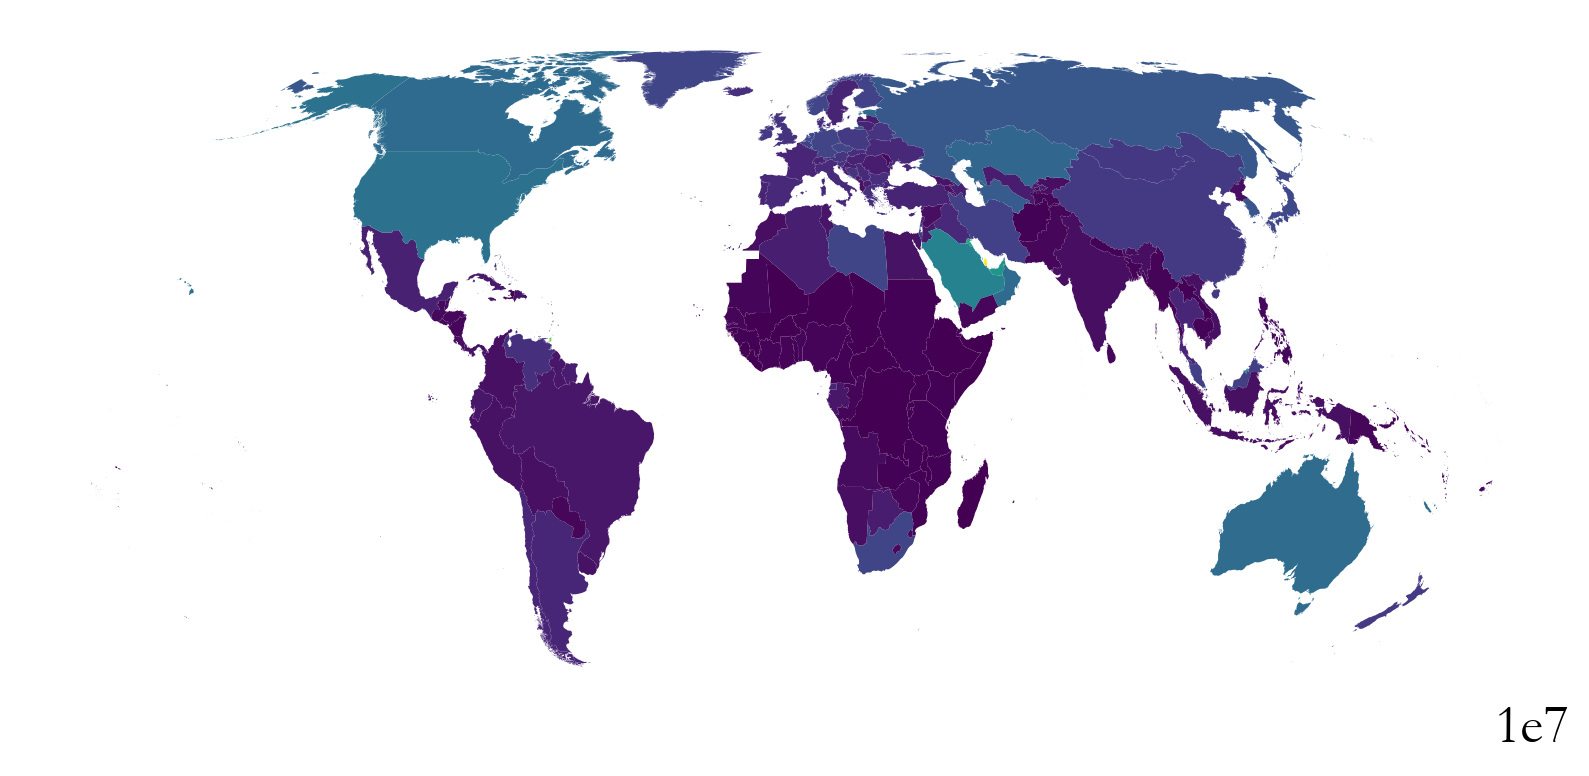

<IPython.core.display.Javascript object>

In [44]:
y = cntry_y["year"].unique().item()
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=200)

vmin, vmax = vmin_vmax(col)
# divider = make_axes_locatable(ax)
# cax1 = divider.append_axes("bottom", size="5%", pad=0)
# vmin = cntry_y["PGDP.CO2.PCAP"].min()
# vmax = 500
# createWorldPlot(cntry_y, col, filelist)

In [67]:
# cntry_y.loc[cntry_y["PGDP.CO2.PCAP"] == cntry_y["PGDP.CO2.PCAP"].max()]
# cntry_y.sort_values(by="CO2E.PC", ascending=False).head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

['graphs/maps/CO2E.PC/1995.jpg']


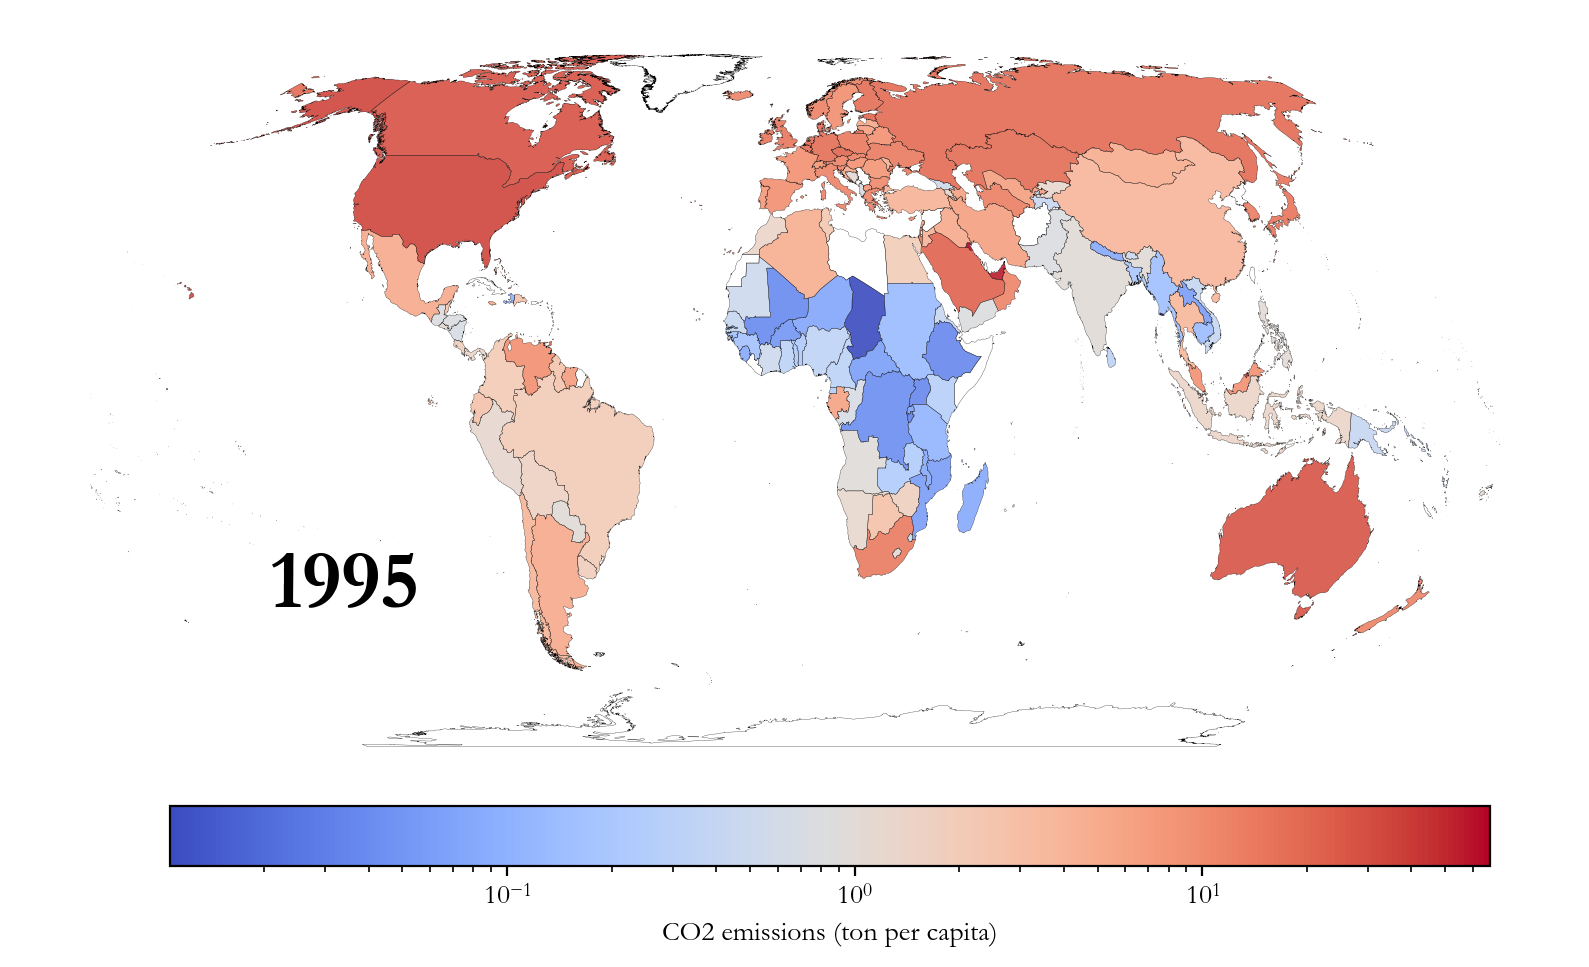

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

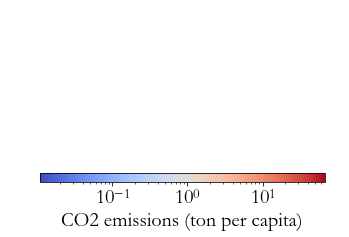

<IPython.core.display.Javascript object>

In [66]:
# vmin, vmax = vmin_vmax(col)
# sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=colors.LogNorm(vmin=vmin, vmax=vmax))
# fig, ax = plt.subplots()
# cbaxes = fig.add_axes([0.2, 0.27, 0.66, 0.03])
# cbar = fig.colorbar(sm, cax=cbaxes, orientation="horizontal", label=val_lab[col])

In [24]:
indicator_df
countries.columns

Index(['FIPS', 'ISO2', 'ISO3', 'UN', 'NAME', 'AREA', 'POP2005', 'REGION',
       'SUBREGION', 'LON', 'LAT', 'geometry'],
      dtype='object')

<IPython.core.display.Javascript object>

In [30]:
import holoviews as hv, panel as pn, param

hv.extension("matplotlib", "bokeh")

'+proj=eqearth'

<IPython.core.display.Javascript object>

In [9]:
## get only countries (country codes) and data from 1990
wb_df = (
    wb_df.loc[
        (wb_df["Country Code"].isin(list(country_df["Code"]))) & (wb_df["year"] >= 1990)
    ]
    .sort_values(by="year")
    .reset_index(drop=True)
)
wb_df.head()

,Country Name,Country Code,year,GDP.MKTP,GDP.PCAP,CO2E.KT,CO2E.PC,GHGT.KT
0,Afghanistan,AFG,1990,NaN,NaN,2614.571,0.210643,1.252802e+04
1,"Venezuela, RB",VEN,1990,1.862539e+11,9486.936761,122162.438,6.222407,2.101026e+05
2,Argentina,ARG,1990,2.407294e+11,7380.115031,112147.861,3.438151,2.665550e+05
3,Nigeria,NGA,1990,2.076502e+11,2180.914504,39196.563,0.411675,1.632742e+05
4,Germany,DEU,1990,1.542829e+12,19423.019762,NaN,NaN,1.256074e+06


<IPython.core.display.Javascript object>

In [62]:
def CO2vsGDPGraphs(cntry_code):
    """
    create and save fig with GDP and CO2 emissions data
    """
    cntry_df = wb_df.loc[wb_df["Country Code"] == cntry_code].reset_index(drop=True)
    cntry_name = cntry_df["Country Name"].unique().item()

    fig = plt.figure()
    ax = plt.axes()

    ax.plot(cntry_df["year"], cntry_df["CO2E.PC"], color="r")
    ax.set_ylabel("CO2 emissions per capita (ton)", color="r")

    ax2 = ax.twinx()
    ax2.plot(cntry_df["year"], cntry_df["GDP.PCAP"], color="b")
    ax2.set_ylabel("GDP per capita (current US$ - PPP)", color="b")
    ax.set_xticks(cntry_df.loc[::5, "year"])
    fig.text(0.9, 0.01, "source: World Bank", ha="right")
    fig.text(
        0.5,
        0.95,
        "{} CO2 Emissions and GDP per capita".format(cntry_name),
        weight="bold",
        size=14,
        ha="center",
    )
    #     fig.savefig(
    #         "graphs/{}_CO2_GDP_PCAP.jpg".format(cntry_code), dpi=200, bbox_inches="tight"
    #     )
    plt.close("all")

    return fig
    # plt.show()

<IPython.core.display.Javascript object>

In [11]:
## get 50 countries with highest total GDP in latest year (2018)
top50gdp = (
    wb_df.loc[wb_df.year == wb_df.year.max()]
    .sort_values(by="GDP.MKTP", ascending=False)
    .reset_index(drop=True)
    .iloc[0:50]
)
# top50gdp["Country Code"]

<IPython.core.display.Javascript object>

In [111]:
for cntry_code in top50gdp["Country Code"]:
    CO2vsGDPGraphs(cntry_code)

<IPython.core.display.Javascript object>

# Holoviews

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
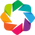

<IPython.core.display.Javascript object>

In [30]:
import holoviews as hv, panel as pn, param

hv.extension("matplotlib", "bokeh")

In [71]:
class CO2GDPhv(param.Parameterized):
    country_name = param.Selector(
        default="United States", objects=wb_df["Country Name"].unique()
    )
    cntry_code = param.Selector(default="USA", objects=wb_df["Country Code"].unique())

    @pn.depends("cntry_code")
    def pnCO2_GDP_PCAP(self, view_fn=CO2vsGDPGraphs):
        return view_fn(self.cntry_code)

    @param.depends("country_name", watch=True)
    def update_cntry_code(self):
        print("update_cntry_code")
        self.cntry_code = country_df.loc[
            country_df["Economy"] == self.country_name, "Code"
        ].item()

    @param.depends("cntry_code", watch=True)
    def view_graph(self):
        graph = self.pnCO2_GDP_PCAP()

        return pn.panel(graph)


test = CO2GDPhv()

<IPython.core.display.Javascript object>

Matplotlib(Figure)
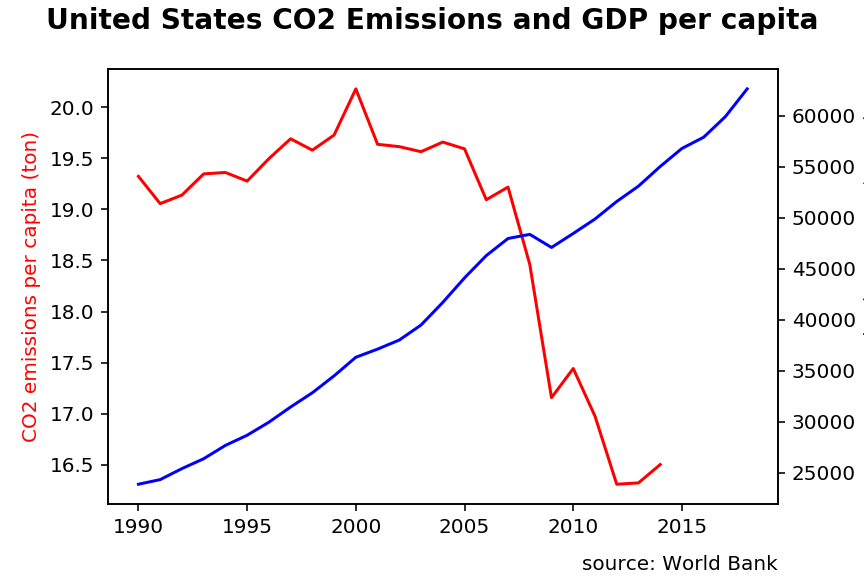

<IPython.core.display.Javascript object>

In [72]:
test.view_graph()

In [79]:
final = pn.Column(test.view_graph, test.param.country_name)

<IPython.core.display.Javascript object>

Column
    [0] ParamMethod(method)
    [1] Select(name='Country name', options=OrderedDict([('Afghanistan...]), value='Nicaragua')
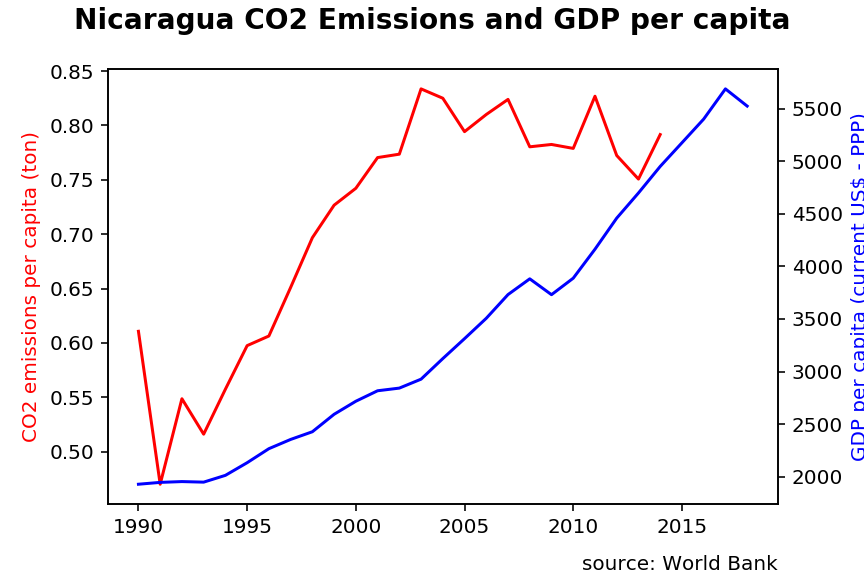

<IPython.core.display.Javascript object>

In [81]:
final

In [17]:
wb_df.loc[wb_df["Country Name"].unique() == "United States"]

,Country Name,Country Code,year,GDP.MKTP,GDP.PCAP,CO2E.KT,CO2E.PC,GHGT.KT
182,United States,USA,1990,5.963144e+12,23888.600009,4823403.118,19.322751,6136093.5


<IPython.core.display.Javascript object>